## Загрузка библиотек

Здесь все как в [практике 2](https://colab.research.google.com/drive/1-0eknp0Qd4d2LxauhNwSZB4_Tb44UlJI?usp=share_link), но без подробностей.

In [4]:
import os
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [5]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"nataliaafonina","key":"362b1fa4088ddc6937c685ff961b6ccf"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
%%capture
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -q book-recommendation-dataset.zip

## Загрузка данных

Для колаборативной фильтрации нам понадобятся только айди пользователей, айди книжек и оценки, которые пользователи дали книжкам.

In [ ]:
ratings = pd.read_csv("Ratings.csv")
ratings.shape

(1149780, 3)

In [ ]:
users = pd.read_csv("Users.csv")
users.head(20)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Приведем айди книжек в числовой вид.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(ratings["ISBN"].tolist())
ratings["ISBN"] = le.transform(ratings["ISBN"])
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,57188,0
1,276726,29750,5
2,276727,107392,0
3,276729,127253,3
4,276729,127287,6


In [ ]:
rating_non_zero = ratings[ratings["Book-Rating"] > 0]

In [ ]:
rating_non_zero.shape

(433671, 3)

## Рекоммендации с помощью pyspark

In [ ]:
ratings_spark = spark.createDataFrame(ratings)

In [ ]:
data_spark = (ratings_spark
    .select(
        'User-ID',
        'ISBN',
        'Book-Rating',
    )
).cache()

In [ ]:
(training, test) = data_spark.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=2, regParam=0.01,
          userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName="mae", labelCol="Book-Rating",
                                predictionCol="prediction")

mae = evaluator.evaluate(predictions)
print("MAE = " + str(mae))

Root-mean-square error = 4.666126064002115
MAE = 2.7026720491073943


In [ ]:
predictions.show()

+-------+----+-----------+-------------+
|User-ID|ISBN|Book-Rating|   prediction|
+-------+----+-----------+-------------+
| 181817|   0|          6|          0.0|
| 238557|  23|          0|          0.0|
|  11676|  38|          0|          0.0|
|  90148|  40|          0|          0.0|
|  13874|  44|         10| 3.3714547E-5|
| 218187|  61|          9|-1.5144024E-5|
| 275650|  61|          0|  3.988348E-6|
|  71285|  61|          0| 7.3098425E-5|
| 214319|  61|          0| 1.8910649E-6|
| 107899|  62|          0| 1.6261085E-5|
|  20859|  62|          0|          0.0|
| 120548|  64|          0| 0.0011038732|
|  71285|  64|          0|  8.719808E-5|
| 137348|  65|          7|          0.0|
|  85772|  66|          7|-3.8124304E-6|
| 236727|  74|          0|-2.2221604E-5|
| 268423|  91|          8|          0.0|
|  11776|  91|          8|          0.0|
|  11944| 121|          9| 0.0014549654|
|  23902| 123|          8| 0.0010884729|
+-------+----+-----------+-------------+
only showing top

In [ ]:
ratings_spark_0 = spark.createDataFrame(rating_non_zero)

In [ ]:
data_spark_0 = (ratings_spark_0
    .select(
        'User-ID',
        'ISBN',
        'Book-Rating',
    )
).cache()

In [ ]:
(training, test) = data_spark_0.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=2, regParam=0.01,
          userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName="mae", labelCol="Book-Rating",
                                predictionCol="prediction")

mae = evaluator.evaluate(predictions)
print("MAE = " + str(mae))

Root-mean-square error = 7.882783808104803
MAE = 7.673238748723926


## Рекоммендации с помощью surprise

In [ ]:
%%capture
!pip install scikit-surprise

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

algo = SVD()
reader = Reader(rating_scale=(0, 11))
data = Dataset.load_from_df(ratings[["User-ID", "ISBN", "Book-Rating"]], reader)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.5102  3.5028  3.5074  3.4939  3.4975  3.5024  0.0061  
MAE (testset)     2.8220  2.8152  2.8208  2.8104  2.8122  2.8161  0.0046  
Fit time          57.47   32.33   32.75   33.06   33.28   37.78   9.85    
Test time         3.42    2.57    2.17    3.67    3.72    3.11    0.63    


{'test_rmse': array([3.51021073, 3.50279986, 3.50740996, 3.49387398, 3.49748405]),
 'test_mae': array([2.82200399, 2.81519641, 2.82082834, 2.81037235, 2.81216706]),
 'fit_time': (57.47108197212219,
  32.33341956138611,
  32.74641156196594,
  33.05614137649536,
  33.28413367271423),
 'test_time': (3.41996169090271,
  2.569528102874756,
  2.1696736812591553,
  3.666555166244507,
  3.7232589721679688)}

Видим, что обе реализации справляются с задачей рекоммендации на этом датасете, но не слишком хорошо. Рейтинг изменяется в диапазоне от 0 до 10, а обе модели ошибаются примерно на 2.5. Однако SVD работает чуть стабильней относительно ALS.

## Задание на лабораторную работу 1

В примерах были рассмотрены два варианта рекомендаций посредством колаборативной фильтрации. В качестве практического задания вам предлагается использовать содержание датасетов, чтобы предсказывать, какую оценку пользователь поставит книге.

Для этого представим задачу предсказания оценки как задачу регрессии, где целевой переменной будет признак Book-Rating.
Тогда план анализа данных будет следующим:
1. Предобработать данные: преобразовать все категориальные данные в числовые (для преобразования названий книжек в вектор попробуйте 3 подхода: [bag-of-words](https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage), [tf-idf](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting), [word2vec](https://radimrehurek.com/gensim/models/word2vec.html), обработать пустые ячейки и неточности в столбцах.
2. Сделать нормировку данных.
3. Обучить и протестировать не менее трех моделей регрессии. Например, [линейную регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [случайный лес](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) и [xgboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training). Можно также попробовать применить нейронную сеть. Например, по этому [туториалу](https://www.tensorflow.org/tutorials/keras/regression).
4. Оценить результаты (RMSE, MAE).

In [7]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
rating_non_zero = ratings[ratings["Book-Rating"] > 0]
books_ratings = pd.merge(
    books, rating_non_zero,
    left_on='ISBN',
    right_on='ISBN',
    how='inner'
)
books_ratings = books_ratings[['ISBN', 'Book-Title', 'User-ID', 'Book-Rating']]


In [8]:
books_ratings

,ISBN,Book-Title,User-ID,Book-Rating
0,0002005018,Clara Callan,8,5
1,0002005018,Clara Callan,11676,8
2,0002005018,Clara Callan,67544,8
3,0002005018,Clara Callan,116866,9
4,0002005018,Clara Callan,123629,9
...,...,...,...,...
383837,0395264707,Dreamsnake,275318,10
383838,1845170423,Cocktail Classics,275970,7
383839,0449906736,Flashpoints: Promise and Peril in a New World,276313,5
383840,0440400988,There's a Bat in Bunk Five,276463,7


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(books_ratings["ISBN"].tolist())
books_ratings["ISBN"] = le.transform(books_ratings["ISBN"])
books_ratings.head()

,ISBN,Book-Title,User-ID,Book-Rating
0,39,Clara Callan,8,5
1,39,Clara Callan,11676,8
2,39,Clara Callan,67544,8
3,39,Clara Callan,116866,9
4,39,Clara Callan,123629,9


In [10]:
books_ratings['Book-Title'] = books_ratings['Book-Title'].str.replace('\W', ' ', regex=True)

In [ ]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 0 to 383841
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ISBN         383842 non-null  int64 
 1   Book-Title   383842 non-null  object
 2   User-ID      383842 non-null  int64 
 3   Book-Rating  383842 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 14.6+ MB


In [ ]:
books_ratings['Book-Rating'].describe()

count    383842.000000
mean          7.626701
std           1.841339
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64

In [ ]:
books_ratings.duplicated().any()

False

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

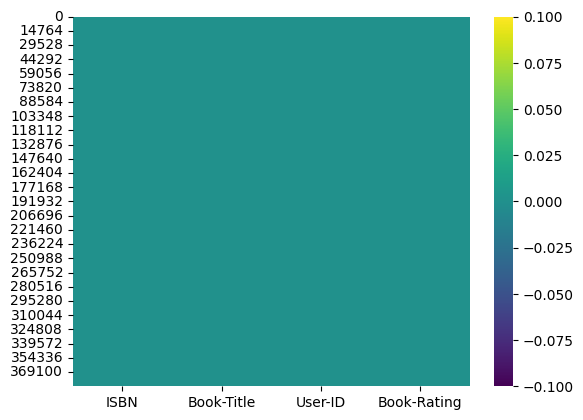

In [ ]:
sns.heatmap(books_ratings.isnull(), cmap='viridis')

Нет повторяющихся или пустых значений.

Text(0, 0.5, 'Frequency')

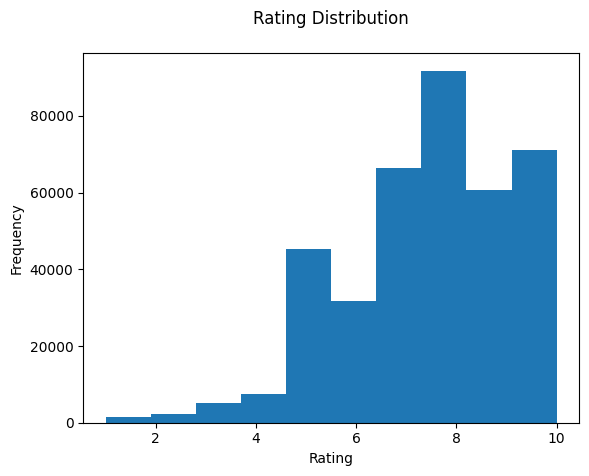

In [ ]:
plt.hist(books_ratings['Book-Rating'])
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Frequency')

In [11]:
users = pd.read_csv("Users.csv", encoding="utf-8")
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
users.duplicated().any()

False

In [ ]:
users['Age'].isna().sum()

110762

In [12]:
users = users.drop(['Age'], axis=1)

In [13]:
data = pd.merge(books_ratings, users, on='User-ID', how='left')

In [14]:
data

,ISBN,Book-Title,User-ID,Book-Rating,Location
0,39,Clara Callan,8,5,"timmins, ontario, canada"
1,39,Clara Callan,11676,8,"n/a, n/a, n/a"
2,39,Clara Callan,67544,8,"toronto, ontario, canada"
3,39,Clara Callan,116866,9,"ottawa, ,"
4,39,Clara Callan,123629,9,"kingston, ontario, canada"
...,...,...,...,...,...
383837,41460,Dreamsnake,275318,10,"klamath falls, oregon, usa"
383838,129765,Cocktail Classics,275970,7,"pittsburgh, pennsylvania, usa"
383839,53784,Flashpoints Promise and Peril in a New World,276313,5,"livermore, california, usa"
383840,48133,There s a Bat in Bunk Five,276463,7,"providence, rhode island, usa"


# preprocessing

Необходимо преобразовать все категориальные данные в числовые. Для начала необходимо токенизировать.

In [15]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [17]:
def preprocess_text(text):
    tokenized = nltk.word_tokenize(text)  # Токенизация
    punct = string.punctuation + "—" + "«" + "»"  # Пунктуация
    tokens = [token.lower() for token in tokenized if token not in punct]  # Удаление пунктуации и приведение к нижнему регистру
    stopwords_list = stopwords.words("english") + ["n/a"]  # Список стоп-слов для английского языка
    tokens = [word for word in tokens if word not in stopwords_list]  # Удаление стоп-слов
    return tokens

data['Processed-Book-Title'] = data['Book-Title'].apply(preprocess_text)
data['Processed-Location'] = data['Location'].apply(preprocess_text)


In [18]:
data['Processed-Book-Title'] = data['Processed-Book-Title'].apply(lambda tokens: ' '.join(tokens))
data['Processed-Location'] = data['Processed-Location'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
data.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Processed-Book-Title,Processed-Location
0,39,Clara Callan,8,5,"timmins, ontario, canada",clara callan,timmins ontario canada
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",clara callan,
2,39,Clara Callan,67544,8,"toronto, ontario, canada",clara callan,toronto ontario canada
3,39,Clara Callan,116866,9,"ottawa, ,",clara callan,ottawa
4,39,Clara Callan,123629,9,"kingston, ontario, canada",clara callan,kingston ontario canada


In [19]:
import random
random.seed(42)
data.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Processed-Book-Title,Processed-Location
346548,140115,Ferne Ufer Der 3 Band der groÃ Â en Highland...,143103,10,"bremerhaven, bremen, germany",ferne ufer der 3 band der groã â en highland saga,bremerhaven bremen germany
160384,45088,Certain Prey,175149,9,"mt. pleasant, michigan, usa",certain prey,mt pleasant michigan usa
112033,67037,The Third Victim,274308,8,"delray beach, florida, usa",third victim,delray beach florida usa
164191,54147,Growing Up,102967,9,"olympia, washington, usa",growing,olympia washington usa
47765,68897,Harry Potter and the Sorcerer s Stone Book 1,164581,9,"costa da caparica, ,",harry potter sorcerer stone book 1,costa da caparica
180389,17707,Leslie Linsley s 15 Minute Decorating Ideas,268734,5,"buffalo, new york, usa",leslie linsley 15 minute decorating ideas,buffalo new york usa
282928,3728,When the Wind Blows,260429,7,"new york, new york, usa",wind blows,new york new york usa
376373,122813,Insight Meditation A Step By Step Course on H...,150124,10,"york, nebraska, usa",insight meditation step step course meditate,york nebraska usa
293375,92804,Tidings Of Comfort amp Joy A Tender Story Of...,59656,8,"schnellville, indiana, usa",tidings comfort amp joy tender story love loss...,schnellville indiana usa
231225,34721,A Walk Among the Tombstones,237912,8,"taipei, n/a, taiwan",walk among tombstones,taipei taiwan


In [ ]:
data.to_csv('processed_data.csv', index=False)

# bag-of-words

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack

In [ ]:
title_vectorizer = CountVectorizer(binary=True)
X_text = title_vectorizer.fit_transform(data['Processed-Book-Title'])

location_vectorizer = CountVectorizer(binary=True)
X_location = location_vectorizer.fit_transform(data['Processed-Location'])

user_id_feature = data['User-ID'].values.reshape(-1, 1)

# Соединение векторов в один вектор
X = hstack([X_text, X_location, user_id_feature])

In [ ]:
from scipy.sparse import hstack

X = X
y = data['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_linreg = model.predict(X_test)

mse_linreg = mean_squared_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mse_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

print(f"MSE: {mse_linreg}")
print(f"RMSE: {rmse_linreg}")
print(f"MAE: {mae_linreg}")

MSE: 3.3762262111032095
RMSE: 1.8374510091709138
MAE: 1.4914616501221203


In [ ]:
y_pred_all_linreg = model.predict(X)

data_linreg = data.copy()
data_linreg['Predicted-Book-Rating'] = y_pred_all_linreg
data_linreg = data_linreg.drop(['Processed-Book-Title', 'Processed-Location'], axis=1)

In [ ]:
random.seed(42)
data_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
371403,119963,Japan s Navy Politics and Paradox 1971 2000,250709,5,"chicago, illinois, usa",7.587306
134837,47611,Evening Class,192700,8,"nashville, tennessee, usa",7.606860
315807,140088,DÃ Â monendÃ Â mmerung 02 Juwelen des Himmels,230427,7,"paderborn, nordrhein-westfalen, germany",7.594143
16856,12269,Icy Sparks,129725,8,"waterloo, ontario, canada",7.628089
364902,39063,Jean Rhys The Complete Novels Voyage in the ...,136714,9,"who knows, i`m on the move, usa now, the world...",7.625733
135147,56339,Lady of Avalon,107326,8,"denver, colorado, usa",7.635640
30829,22110,Resistance A Novel,168813,7,"st. louis, missouri, usa",7.614913
125772,48915,The Lunatic Cafe Anita Blake Vampire Hunter ...,26544,10,"woodbridge, virginia, usa",7.662871
225973,74903,TEETH,216225,7,"st. louis, missouri, usa",7.598930
89013,11762,Ivanhoe Penguin Popular Classics,140423,8,"norwich, england, united kingdom",7.624483


In [ ]:
title_counts = data_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_linreg[data_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"turner, oregon, usa",7.578295
9808,21945,The Lovely Bones A Novel,277752,7,"baton rouge, louisiana, usa",7.578189
9809,21945,The Lovely Bones A Novel,278633,9,"sandy, utah, usa",7.577892
9810,21945,The Lovely Bones A Novel,638,10,"san diego, california, usa",7.671604
9811,21945,The Lovely Bones A Novel,709,3,"roanoke, virginia, usa",7.671580


In [ ]:
data_linreg.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,39,Clara Callan,8,5,"timmins, ontario, canada",7.671816
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",7.667883
2,39,Clara Callan,67544,8,"toronto, ontario, canada",7.649050
3,39,Clara Callan,116866,9,"ottawa, ,",7.632424
4,39,Clara Callan,123629,9,"kingston, ontario, canada",7.630144


xgboost

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")

MSE: 3.13418821245091
RMSE: 1.7703638644219188
MAE: 1.4225247518251247


In [ ]:
y_pred_all_xgb = xgb_model.predict(X)
data_xgb = data.copy()
data_xgb['Predicted-Book-Rating'] = y_pred_all_xgb
data_xgb = data_xgb.drop(['Processed-Book-Title', 'Processed-Location'], axis=1)

In [ ]:
random.seed(42)
data_xgb.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
12085,104416,Left Behind A Novel of the Earth s Last Days ...,27947,6,"lima, ohio, usa",7.647022
194915,28598,Dangerous,53220,7,"fullerton, california, usa",7.647022
207773,70233,The Beast from the East Goosebumps No 43,67782,10,"rainsville, alabama, usa",7.647022
242212,8551,On the Road Modern Classics S,183999,8,"norwich, england, united kingdom",7.593968
13431,65367,An Inconvenient Woman,170518,5,"gaithersburg, maryland, usa",7.641730
201343,97774,The Uncommon Wisdom of Oprah Winfrey A Portra...,21507,8,"claremore, oklahoma, usa",7.647022
267964,146091,Viaje Al Corazon del Mar Negro,263407,4,"barcelona, catalunya, spain",7.429490
375934,86601,Feng Shui Chic Change Your Life With Spirit a...,123064,3,"vancouver, ,",7.529050
35631,2158,The Poisonwood Bible,38995,10,"woodbine, maryland, usa",7.751631
108544,29202,Fishbowl Red Dress Ink Paperback,56554,9,"rural hall, north carolina, usa",7.647022


In [ ]:
title_counts = data_xgb['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_xgb[data_xgb['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"turner, oregon, usa",7.699168
9808,21945,The Lovely Bones A Novel,277752,7,"baton rouge, louisiana, usa",7.699168
9809,21945,The Lovely Bones A Novel,278633,9,"sandy, utah, usa",7.699168
9810,21945,The Lovely Bones A Novel,638,10,"san diego, california, usa",7.790362
9811,21945,The Lovely Bones A Novel,709,3,"roanoke, virginia, usa",7.704460


knn

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"MSE: {mse_knn}")
print(f"RMSE: {rmse_knn}")
print(f"MAE: {mae_knn}")

MSE: 3.1226323125219815
RMSE: 1.7670971429216848
MAE: 1.339045708554234


In [ ]:
y_pred_all_knn = knn_model.predict(X)
data_knn = data.copy()
data_knn['Predicted-Book-Rating'] = y_pred_all_knn
data_knn = data_knn.drop(['Processed-Book-Title', 'Processed-Location'], axis=1)

In [ ]:
random.seed(42)
data_knn.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
139887,89743,The Serpent s Shadow,257204,10,"akron, ohio, usa",9.6
214241,26274,Queen of Camelot,159655,8,"austin, texas, usa",7.8
284088,142416,Die Klavierspielerin Roman,161129,3,"greifswald, mecklenburg-vorpommern, germany",7.8
292649,93169,House of Secrets,123981,9,"phoenix, arizona, usa",8.2
356211,63145,Why Not the Best,78448,8,"fairfax, virginia, usa",8.6
97126,51649,Last Man Standing,21356,5,"westwood, new jersey, usa",5.8
270458,54853,Murder Can Ruin Your Looks Desiree Shapiro My...,219497,7,"englewood, florida, usa",7.4
63590,95707,A Confederacy of Dunces Evergreen Book,227467,4,"san francisco, california, usa",5.4
17782,22109,The Pilot s Wife A Novel Tag Author of the ...,244627,10,"shelbyville, tennessee, usa",10.0
26440,75948,Lonesome Dove,112856,8,"beijing, beijing, china",7.4


In [ ]:
data_knn.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,39,Clara Callan,8,5,"timmins, ontario, canada",5.4
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",8.0
2,39,Clara Callan,67544,8,"toronto, ontario, canada",7.2
3,39,Clara Callan,116866,9,"ottawa, ,",8.2
4,39,Clara Callan,123629,9,"kingston, ontario, canada",7.2


In [ ]:
title_counts = data_knn['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_knn[data_knn['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"turner, oregon, usa",6.6
9808,21945,The Lovely Bones A Novel,277752,7,"baton rouge, louisiana, usa",7.6
9809,21945,The Lovely Bones A Novel,278633,9,"sandy, utah, usa",7.6
9810,21945,The Lovely Bones A Novel,638,10,"san diego, california, usa",9.4
9811,21945,The Lovely Bones A Novel,709,3,"roanoke, virginia, usa",5.0


In [ ]:
data_knn

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,39,Clara Callan,8,5,"timmins, ontario, canada",5.4
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",8.0
2,39,Clara Callan,67544,8,"toronto, ontario, canada",7.2
3,39,Clara Callan,116866,9,"ottawa, ,",8.2
4,39,Clara Callan,123629,9,"kingston, ontario, canada",7.2
...,...,...,...,...,...,...
383837,41460,Dreamsnake,275318,10,"klamath falls, oregon, usa",9.6
383838,129765,Cocktail Classics,275970,7,"pittsburgh, pennsylvania, usa",9.4
383839,53784,Flashpoints Promise and Peril in a New World,276313,5,"livermore, california, usa",7.0
383840,48133,There s a Bat in Bunk Five,276463,7,"providence, rhode island, usa",7.6


In [ ]:
merged_data = pd.concat([data['ISBN'], data['User-ID'], data['Book-Title'], data['Book-Rating'], data_linreg['Predicted-Book-Rating'], data_xgb['Predicted-Book-Rating'], data_knn['Predicted-Book-Rating']], axis=1, keys=['ISBN', 'User-ID', 'Book-Title', 'Book-Rating', 'Prediction_bow_linreg', 'Prediction_bow_xgb', 'Prediction_bow_knn'])
merged_data

,ISBN,User-ID,Book-Title,Book-Rating,Prediction_bow_linreg,Prediction_bow_xgb,Prediction_bow_knn
0,39,8,Clara Callan,5,7.671816,7.529050,5.4
1,39,11676,Clara Callan,8,7.667883,7.529050,8.0
2,39,67544,Clara Callan,8,7.649050,7.529050,7.2
3,39,116866,Clara Callan,9,7.632424,7.529050,8.2
4,39,123629,Clara Callan,9,7.630144,7.529050,7.2
...,...,...,...,...,...,...,...
383837,41460,275318,Dreamsnake,10,7.579010,7.641730,9.6
383838,129765,275970,Cocktail Classics,7,7.578790,7.706649,9.4
383839,53784,276313,Flashpoints Promise and Peril in a New World,5,7.578675,7.641730,7.0
383840,48133,276463,There s a Bat in Bunk Five,7,7.578624,7.641730,7.6


In [ ]:
merged_data.to_csv('merged_data_bow.csv', index=False)

# tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(binary=True)
X_text_tfidf = tfidf_vectorizer.fit_transform(data['Processed-Book-Title'])

X_location = tfidf_vectorizer.fit_transform(data['Processed-Location'])

user_id_feature = data['User-ID'].values.reshape(-1, 1)

# Соединение векторов в один вектор
X = hstack([X_text_tfidf, X_location, user_id_feature])

In [ ]:
X_tfidf = X
y_tfidf = data['Book-Rating']

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

линейная регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_linreg = model.predict(X_test_tfidf)

mse_tfidf_linreg = mean_squared_error(y_test_tfidf, y_pred_tfidf_linreg)
rmse_tfidf_linreg = np.sqrt(mse_tfidf_linreg)
mae_tfidf_linreg = mean_absolute_error(y_test_tfidf, y_pred_tfidf_linreg)

print(f"MSE: {mse_tfidf_linreg}")
print(f"RMSE: {rmse_tfidf_linreg}")
print(f"MAE: {mae_tfidf_linreg}")

MSE: 3.376226211103613
RMSE: 1.8374510091710237
MAE: 1.4914616501224036


In [ ]:
y_pred_tfidf_all_linreg = model.predict(X_tfidf)
data_tfidf_linreg = data.copy()
data_tfidf_linreg['Predicted-Book-Rating'] = y_pred_tfidf_all_linreg
data_tfidf_linreg = data_tfidf_linreg.drop(['Processed-Book-Title', 'Processed-Location'], axis=1)

In [ ]:
random.seed(42)
data_tfidf_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
44217,47146,One,166510,8,"calgary, alberta, canada",7.615689
292121,87791,Shout Down the Moon,191009,5,"palm desert, california, usa",7.607430
89517,50509,Geek Love,174693,8,"tallahassee, florida, usa",7.612930
32826,53654,Les Miserables,183541,9,"winter springs, florida, usa",7.609948
129410,145573,El Capitan Alatriste,165392,9,"portalegre, alto alentejo, portugal",7.616066
183745,119279,Skyward,229055,6,"grand rapids, michigan, usa",7.594605
356137,116988,Help4Add High School,176846,7,"wheaton, illinois, usa",7.612205
241356,38581,The Edible Woman,105517,8,"calgary, alberta, canada",7.636249
63548,95707,A Confederacy of Dunces Evergreen Book,48357,8,"houston, texas, usa",7.655518
227684,3429,Ten Thousand Lovers A Novel,71551,6,"minneapolis, minnesota, usa",7.647699


In [ ]:
data_tfidf_linreg.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,39,Clara Callan,8,5,"timmins, ontario, canada",7.671816
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",7.667883
2,39,Clara Callan,67544,8,"toronto, ontario, canada",7.649050
3,39,Clara Callan,116866,9,"ottawa, ,",7.632424
4,39,Clara Callan,123629,9,"kingston, ontario, canada",7.630144


In [ ]:
title_counts = data_tfidf_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_tfidf_linreg[data_tfidf_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"turner, oregon, usa",7.578295
9808,21945,The Lovely Bones A Novel,277752,7,"baton rouge, louisiana, usa",7.578189
9809,21945,The Lovely Bones A Novel,278633,9,"sandy, utah, usa",7.577892
9810,21945,The Lovely Bones A Novel,638,10,"san diego, california, usa",7.671604
9811,21945,The Lovely Bones A Novel,709,3,"roanoke, virginia, usa",7.671580


xgboost

In [ ]:
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_xgb = xgb_model.predict(X_test_tfidf)

mse_tfidf_xgb = mean_squared_error(y_test_tfidf, y_pred_tfidf_xgb)
rmse_tfidf_xgb = np.sqrt(mse_tfidf_xgb)
mae_tfidf_xgb = mean_absolute_error(y_test_tfidf, y_pred_tfidf_xgb)

print(f"MSE: {mse_tfidf_xgb}")
print(f"RMSE: {rmse_tfidf_xgb}")
print(f"MAE: {mae_tfidf_xgb}")

MSE: 3.114167720983109
RMSE: 1.7647004621133606
MAE: 1.4164280137736363


In [ ]:
y_pred_tfidf_all_xgb = xgb_model.predict(X_tfidf)
data_tfidf_xgb = data.copy()
data_tfidf_xgb['Predicted-Book-Rating'] = y_pred_tfidf_all_xgb
data_tfidf_xgb = data_tfidf_xgb.drop(['Processed-Book-Title', 'Processed-Location'], axis=1)

In [ ]:
random.seed(42)
data_tfidf_xgb.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
379686,34705,Discover It Yourself Where in the World Are You,175636,9,"san antonio, texas, usa",7.611475
109649,53289,Longshot,83156,8,"richmond, virginia, usa",7.523031
86170,47685,The Ghost,67930,10,"colton, california,",7.716907
282700,118908,The Little Book of Money,259977,7,"vancouver, british columbia, canada",7.646172
211510,124886,The Midnight Club,150979,10,"greencastle, pennsylvania, usa",7.623422
310675,18722,The Cold Blue Blood A Berger amp Mitry Mystery,98391,9,"morrow, georgia, usa",8.726057
326944,111104,Complete Pun Book,79441,7,"spruce grove, alberta, canada",7.795002
319715,4194,V Perennial Classics,203827,10,"madrid, madrid, spain",7.344237
375623,803,HOW TO SPEAK HOW TO LISTEN,189334,9,"ottawa, ontario, canada",7.527846
341152,139131,LÃ Â cher Die Geheimnisse von Green Lake A...,143436,9,"lohmar, nordrhein-westfalen, germany",7.331422


In [ ]:
data_tfidf_xgb.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,39,Clara Callan,8,5,"timmins, ontario, canada",7.527846
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",7.527846
2,39,Clara Callan,67544,8,"toronto, ontario, canada",7.527846
3,39,Clara Callan,116866,9,"ottawa, ,",7.527846
4,39,Clara Callan,123629,9,"kingston, ontario, canada",7.527846


In [ ]:
data_tfidf_xgb[data_tfidf_xgb['ISBN'] == 46020].head(10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
55208,46020,Harry Potter and the Chamber of Secrets Book 2,278356,8,"lakeland, tennessee, usa",8.850418
55209,46020,Harry Potter and the Chamber of Secrets Book 2,254,9,"minneapolis, minnesota, usa",8.670554
55210,46020,Harry Potter and the Chamber of Secrets Book 2,4896,10,"ploiesti, prahova, romania",9.539628
55211,46020,Harry Potter and the Chamber of Secrets Book 2,8245,8,"torrance, california, usa",8.784005
55212,46020,Harry Potter and the Chamber of Secrets Book 2,10560,10,"chicago, illinois, usa",8.583675
55213,46020,Harry Potter and the Chamber of Secrets Book 2,11676,8,"n/a, n/a, n/a",8.604555
55214,46020,Harry Potter and the Chamber of Secrets Book 2,12824,8,"long beach, california, usa",8.815174
55215,46020,Harry Potter and the Chamber of Secrets Book 2,16181,10,"gelnhausen, hessen, germany",8.349434
55216,46020,Harry Potter and the Chamber of Secrets Book 2,17667,7,"iowa city, iowa, usa",8.639094
55217,46020,Harry Potter and the Chamber of Secrets Book 2,19336,9,"leavenworth, kansas, usa",8.750730


KNN

In [ ]:
knn_tfidf_model = KNeighborsRegressor(n_neighbors=5)

knn_tfidf_model.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_knn = knn_tfidf_model.predict(X_test_tfidf)

mse_tfidf_knn = mean_squared_error(y_test_tfidf, y_pred_tfidf_knn)
rmse_tfidf_knn = np.sqrt(mse_tfidf_knn)
mae_tfidf_knn = mean_absolute_error(y_test_tfidf, y_pred_tfidf_knn)

print(f"MSE: {mse_tfidf_knn}")
print(f"RMSE: {rmse_tfidf_knn}")
print(f"MAE: {mae_tfidf_knn}")

MSE: 3.07983118185726
RMSE: 1.7549447802871918
MAE: 1.3188109783897146


In [ ]:
y_pred_tfidf_all_knn = knn_tfidf_model.predict(X_tfidf)
data_tfidf_knn = data.copy()
data_tfidf_knn['Predicted-Book-Rating'] = y_pred_tfidf_all_knn
data_tfidf_knn = data_tfidf_knn.drop(['Processed-Book-Title', 'Processed-Location'], axis=1)

In [ ]:
random.seed(42)
data_tfidf_knn.sample(n=10)

In [ ]:
data_tfidf_knn.head(5)

In [ ]:
result = data_tfidf_knn[data_tfidf_knn['ISBN'] == 46020]
result.head(10)

In [ ]:
merged_data = pd.concat([data['ISBN'], data['User-ID'], data['Book-Title'], data['Book-Rating'], data_tfidf_linreg['Predicted-Book-Rating'], data_tfidf_xgb['Predicted-Book-Rating']], axis=1, keys=['ISBN', 'User-ID', 'Book-Title', 'Book-Rating', 'Prediction_tfidf_linreg', 'Prediction_tfidf_xgb'])
merged_data

,ISBN,User-ID,Book-Title,Book-Rating,Prediction_tfidf_linreg,Prediction_tfidf_xgb
0,39,8,Clara Callan,5,7.671816,7.527846
1,39,11676,Clara Callan,8,7.667883,7.527846
2,39,67544,Clara Callan,8,7.649050,7.527846
3,39,116866,Clara Callan,9,7.632424,7.527846
4,39,123629,Clara Callan,9,7.630144,7.527846
...,...,...,...,...,...,...
383837,41460,275318,Dreamsnake,10,7.579010,7.642560
383838,129765,275970,Cocktail Classics,7,7.578790,7.574427
383839,53784,276313,Flashpoints Promise and Peril in a New World,5,7.578675,7.583351
383840,48133,276463,There s a Bat in Bunk Five,7,7.578624,7.642560


In [ ]:
merged_data.to_csv('merged_data_tfidf.csv', index=False)

# word2vec

In [20]:
data['Processed-Book-Title'].unique()

array(['clara callan', 'decision normandy',
       'flu story great influenza pandemic 1918 search virus caused', ...,
       'cocktail classics', 'flashpoints promise peril new world',
       'one one hundred'], dtype=object)

In [21]:
import urllib.request # библиотека для скачивания данных
import gensim # библиотека для загрузки и использвоания моделй w2v
from gensim.models import word2vec # непосредственно методы w2v
from gensim.models import Word2Vec

In [22]:
# Функция для создания векторов Word2Vec
def create_word2vec_vectors(column):
    preprocessed_corpus = column.astype(str).apply(lambda text: text.split())
    model = Word2Vec(sentences=preprocessed_corpus, vector_size=100, window=5, min_count=1, workers=4)
    vectors = column.apply(lambda row: np.mean([model.wv[word] for word in str(row).split() if word in model.wv], axis=0))
    return np.vstack(vectors)

In [25]:
user_column = data['User-ID']

# Создание векторов для каждого столбца
user_vectors = StandardScaler().fit_transform(user_column.values.reshape(-1, 1))
title_vectors = create_word2vec_vectors(data['Book-Title'])
location_vectors = create_word2vec_vectors(data['Location'])

In [26]:
# Проверка длины векторов
def check_vector_lengths(*vectors):
    lengths = [vector.shape[1] for vector in vectors]
    unique_lengths = set(lengths)
    if len(unique_lengths) == 1:
        print("Все векторы имеют одинаковую длину.")
    else:
        print("Длины векторов различны.")

In [27]:
# Проверка длины векторов
check_vector_lengths(user_vectors, title_vectors, location_vectors)

Длины векторов различны.


In [28]:
# Объединение векторов
combined_vectors = np.column_stack((user_vectors, title_vectors, location_vectors))

In [29]:
data['Combined_Vector_Column'] = combined_vectors.tolist()
data

,ISBN,Book-Title,User-ID,Book-Rating,Location,Processed-Book-Title,Processed-Location,Combined_Vector_Column
0,39,Clara Callan,8,5,"timmins, ontario, canada",clara callan,timmins ontario canada,"[-1.6901062651036118, -0.11613597720861435, -0..."
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",clara callan,,"[-1.5451300990911885, -0.11613597720861435, -0..."
2,39,Clara Callan,67544,8,"toronto, ontario, canada",clara callan,toronto ontario canada,"[-0.8509641372483653, -0.11613597720861435, -0..."
3,39,Clara Callan,116866,9,"ottawa, ,",clara callan,ottawa,"[-0.23813293566585425, -0.11613597720861435, -..."
4,39,Clara Callan,123629,9,"kingston, ontario, canada",clara callan,kingston ontario canada,"[-0.15410192686040186, -0.11613597720861435, -..."
...,...,...,...,...,...,...,...,...
383837,41460,Dreamsnake,275318,10,"klamath falls, oregon, usa",dreamsnake,klamath falls oregon usa,"[1.7306503568436151, -0.00689092418178916, 0.0..."
383838,129765,Cocktail Classics,275970,7,"pittsburgh, pennsylvania, usa",cocktail classics,pittsburgh pennsylvania usa,"[1.7387515275875387, -0.795184314250946, 0.145..."
383839,53784,Flashpoints Promise and Peril in a New World,276313,5,"livermore, california, usa",flashpoints promise peril new world,livermore california usa,"[1.7430133398040506, -2.0345919132232666, 0.12..."
383840,48133,There s a Bat in Bunk Five,276463,7,"providence, rhode island, usa",bat bunk five,providence rhode island usa,"[1.744877106079493, -1.2148231267929077, 0.012..."


In [30]:
# Проверка длин векторов еще раз
vector_lengths = data['Combined_Vector_Column'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)
unique_lengths = vector_lengths.nunique()

if unique_lengths == 1:
    print("Все векторы имеют одинаковую длину.")
else:
    print("Длины векторов различны.")

Все векторы имеют одинаковую длину.


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [31]:
X = combined_vectors
y = data['Book-Rating']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Масштабирование признаков (стандартизация)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



> Линейная регрессия



In [ ]:
# Инициализация модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test_scaled)

# Оценка качества модели
mse_w2v = mean_squared_error(y_test, y_pred)
rmse_w2v = np.sqrt(mse_w2v)
mae_w2v = mean_absolute_error(y_test, y_pred)
print("MSE:", mse_w2v)
print("RMSE:", rmse_w2v)
print("MAE:", mae_w2v)

MSE: 3.2727204051451824
RMSE: 1.8090661693661685
MAE: 1.4546585527718583


In [ ]:
y_pred_all_linreg = model.predict(X)

data_w2v_linreg = data.copy()
data_w2v_linreg['Predicted-Book-Rating'] = y_pred_all_linreg
data_w2v_linreg = data_w2v_linreg.drop(['Processed-Book-Title', 'Combined_Vector_Column', 'Processed-Location'], axis=1)

In [ ]:
import random

In [ ]:
random.seed(42)
data_w2v_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
32083,0060929596,As Nature Made Him : The Boy Who Was Raised as...,122801,8,"elm grove, wisconsin, usa",7.974055
372277,1591291852,Who Needs a Hero,147058,7,"fairbury, nebraska, usa",7.863446
33321,0688177751,Miss Julia Speaks Her Mind : A Novel,258771,6,"portland, oregon, usa",7.878940
87359,038073186X,Shutter Island,240144,7,"muskego, wisconsin, usa",8.198683
36818,067976402X,Snow Falling on Cedars,78589,1,"sterling, virginia, usa",8.033445
362079,1412000831,Happy 4 Life: Here's How to Do It,127129,7,"langley, british columbia, canada",7.930939
305820,3442449820,Undank ist der VÃ?Â¤ter Lohn.,243768,7,"basel, basel-stadt, switzerland",8.069268
149802,0515085928,Death in Ecstasy,240144,8,"muskego, wisconsin, usa",8.163550
120922,0345445848,Big Cherry Holler: A Big Stone Gap Novel (Ball...,16106,9,"albany, california, usa",7.872018
236993,0843103914,Wee Sing and Play Book,31556,6,"chula vista, california, usa",7.818758


In [ ]:
title_counts = data_w2v_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_w2v_linreg[data_w2v_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
9807,0316666343,The Lovely Bones: A Novel,277439,7,"turner, oregon, usa",7.896519
9808,0316666343,The Lovely Bones: A Novel,277752,7,"baton rouge, louisiana, usa",7.784088
9809,0316666343,The Lovely Bones: A Novel,278633,9,"sandy, utah, usa",7.887325
9810,0316666343,The Lovely Bones: A Novel,638,10,"san diego, california, usa",7.744150
9811,0316666343,The Lovely Bones: A Novel,709,3,"roanoke, virginia, usa",8.076972


In [ ]:
data_w2v_linreg.to_csv('data_w2v_linreg.csv', index=False)



> xgboost


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")

MSE: 2.9991716168456453
RMSE: 1.7318116574401632
MAE: 1.3749380717298458


In [ ]:
y_pred_all_xgb = xgb_model.predict(X)
data_xgb = data.copy()
data_xgb['Predicted-Book-Rating'] = y_pred_all_xgb
data_xgb = data_xgb.drop(['Processed-Book-Title', 'Processed-Location', 'Combined_Vector_Column'], axis=1)

In [ ]:
random.seed(42)
data_xgb.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
380858,3442454123,Unter den ZitronenbÃ?Â¤umen. Ein Optimist in A...,214316,7,"guetersloh, hamburg, germany",7.683971
143655,0373270976,"Night Shield (Intimate Moments, 1027)",152061,8,"estero, florida, usa",7.663329
351888,1562827529,Cooking With Regis &amp; Kathie Lee,176297,5,"murfreesboro, tennessee, usa",7.893629
296974,3257212763,Charles Ryders Tage vor Brideshead. ErzÃ?Â¤hlu...,191720,9,"ravensburg, baden-württemberg, germany",7.721732
333673,037541214X,The Yokota Officers Club,51992,10,"west fairlee, vermont, usa",7.883922
301369,0671454064,VELVET ANGEL,242006,8,"santo domingo, distrito nacional, dominican re...",7.749131
136114,0553583441,Touching Evil,62133,8,"germantown, maryland, usa",7.828731
34203,0060514949,Dead Ringer,200402,6,"campbell, california, usa",7.445835
333280,1881649075,Rock and Roll Cookbook: Favorite Recipes from ...,88733,7,"houston, texas, usa",8.211812
28338,0553256696,Hiding Place,55492,10,"antioch, illinois, usa",7.810234


In [ ]:
title_counts = data_xgb['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_xgb[data_xgb['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
9807,0316666343,The Lovely Bones: A Novel,277439,7,"turner, oregon, usa",7.661409
9808,0316666343,The Lovely Bones: A Novel,277752,7,"baton rouge, louisiana, usa",7.835145
9809,0316666343,The Lovely Bones: A Novel,278633,9,"sandy, utah, usa",7.839930
9810,0316666343,The Lovely Bones: A Novel,638,10,"san diego, california, usa",7.900577
9811,0316666343,The Lovely Bones: A Novel,709,3,"roanoke, virginia, usa",7.915407


In [ ]:
data_xgb.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,0002005018,Clara Callan,8,5,"timmins, ontario, canada",7.587706
1,0002005018,Clara Callan,11676,8,"n/a, n/a, n/a",7.588177
2,0002005018,Clara Callan,67544,8,"toronto, ontario, canada",7.658059
3,0002005018,Clara Callan,116866,9,"ottawa, ,",7.571661
4,0002005018,Clara Callan,123629,9,"kingston, ontario, canada",7.636849


In [ ]:
data_xgb.to_csv('data_w2v_xgb.csv', index=False)



> knn



In [33]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"MSE: {mse_knn}")
print(f"RMSE: {rmse_knn}")
print(f"MAE: {mae_knn}")

MSE: 3.580088837942399
RMSE: 1.8921122688525644
MAE: 1.4829579648035012


In [34]:
y_pred_all_knn = knn_model.predict(X)
data_knn = data.copy()
data_knn['Predicted-Book-Rating'] = y_pred_all_knn
data_knn = data_knn.drop(['Processed-Book-Title', 'Processed-Location', 'Combined_Vector_Column'], axis=1)

In [35]:
random.seed(42)
data_knn.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
23457,34208,One Hundred Years of Solitude,145806,9,"brooklyn, new york, usa",7.6
275416,80112,Home American Writers Remember Rooms of Their...,60178,7,"west bloomfield, michigan, usa",7.6
113025,43983,The Talisman,158295,8,"cleveland, ohio, usa",7.0
69413,40294,Love in the Time of Cholera,112512,10,"ottawa, ontario, canada",8.4
14416,38305,The Partner,184513,5,"navarre, florida, usa",8.0
187837,75884,ALMOST HEAVEN,16876,5,"west long branch, new jersey, usa",7.8
151135,53759,Tales from Margaritaville Fictional Facts and...,39227,10,"san diego, california, usa",8.4
166066,44497,Terminal,190708,5,"ramona, california, usa",8.8
234537,57575,The Mammy,164956,8,"waterdown, ontario, canada",7.8
310174,60170,Lady in Waiting,98391,8,"morrow, georgia, usa",8.8


In [36]:
data_knn.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,39,Clara Callan,8,5,"timmins, ontario, canada",7.2
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",7.0
2,39,Clara Callan,67544,8,"toronto, ontario, canada",6.4
3,39,Clara Callan,116866,9,"ottawa, ,",7.4
4,39,Clara Callan,123629,9,"kingston, ontario, canada",7.0


In [37]:
result = data_knn[data_knn['ISBN'] == 46020]
result.head(10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
55208,46020,Harry Potter and the Chamber of Secrets Book 2,278356,8,"lakeland, tennessee, usa",9.4
55209,46020,Harry Potter and the Chamber of Secrets Book 2,254,9,"minneapolis, minnesota, usa",9.4
55210,46020,Harry Potter and the Chamber of Secrets Book 2,4896,10,"ploiesti, prahova, romania",9.0
55211,46020,Harry Potter and the Chamber of Secrets Book 2,8245,8,"torrance, california, usa",8.8
55212,46020,Harry Potter and the Chamber of Secrets Book 2,10560,10,"chicago, illinois, usa",9.0
55213,46020,Harry Potter and the Chamber of Secrets Book 2,11676,8,"n/a, n/a, n/a",8.8
55214,46020,Harry Potter and the Chamber of Secrets Book 2,12824,8,"long beach, california, usa",9.0
55215,46020,Harry Potter and the Chamber of Secrets Book 2,16181,10,"gelnhausen, hessen, germany",10.0
55216,46020,Harry Potter and the Chamber of Secrets Book 2,17667,7,"iowa city, iowa, usa",8.0
55217,46020,Harry Potter and the Chamber of Secrets Book 2,19336,9,"leavenworth, kansas, usa",8.8


In [38]:
data_knn.to_csv('data_w2v_knn.csv', index=False)